In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from xgboost import XGBClassifier, plot_importance

In [60]:
df = pd.read_csv('passing_data.csv')

In [61]:
model_df = df.copy()

In [62]:
target = 'success'
features = [
    'x', 'mirrored_y', 'pass_angle', 'pass_distance',
    'body_part_name', 'is_cross', 'play_pattern_name', 'pass_height_name',
    'pass_count_in_possession', 'prev_carry_distance', 'vertical_velocity',
    'prev_action_is_teammate', 'prev_type'
]

In [63]:
X = model_df[features]
y = model_df[target]

In [64]:
X_encoded = pd.get_dummies(X, columns=[
    'body_part_name', 
    'play_pattern_name', 
    'pass_height_name', 
    'prev_type'
])


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training on {len(X_train)} passes.")
print(f"Testing on {len(X_test)} passes.")

Training on 32269 passes.
Testing on 8068 passes.


In [66]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [67]:
import numpy as np

# 1. Check which columns have infinite values (Optional, for debugging)
cols_with_inf = X_train.columns[np.isinf(X_train).any()].tolist()
print(f"Columns containing Infinity: {cols_with_inf}")

# 2. Replace Infinity with NaN (XGBoost handles NaNs natively)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)



Columns containing Infinity: ['vertical_velocity']


In [68]:
model = XGBClassifier(
    n_estimators=200,         # Number of trees
    max_depth=4,              # Shallow trees (avoids memorizing the data)
    learning_rate=0.05,       # Slower learning = more robust model
    colsample_bytree=0.8,     # Randomly select features per tree
    subsample=0.8,            # Randomly select rows per tree
    random_state=42,
    n_jobs=-1                 # Use all your CPU cores
)

model.fit(X_train, y_train)
print("Training Complete!")

Training Complete!


In [69]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

logloss = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Log Loss: {logloss}")
print(f"ROC AUC: {roc_auc}")
print(f"Brier Score: {brier_score}")

Log Loss: 0.2437986528907223
ROC AUC: 0.9089116108184215
Brier Score: 0.07323909421939068


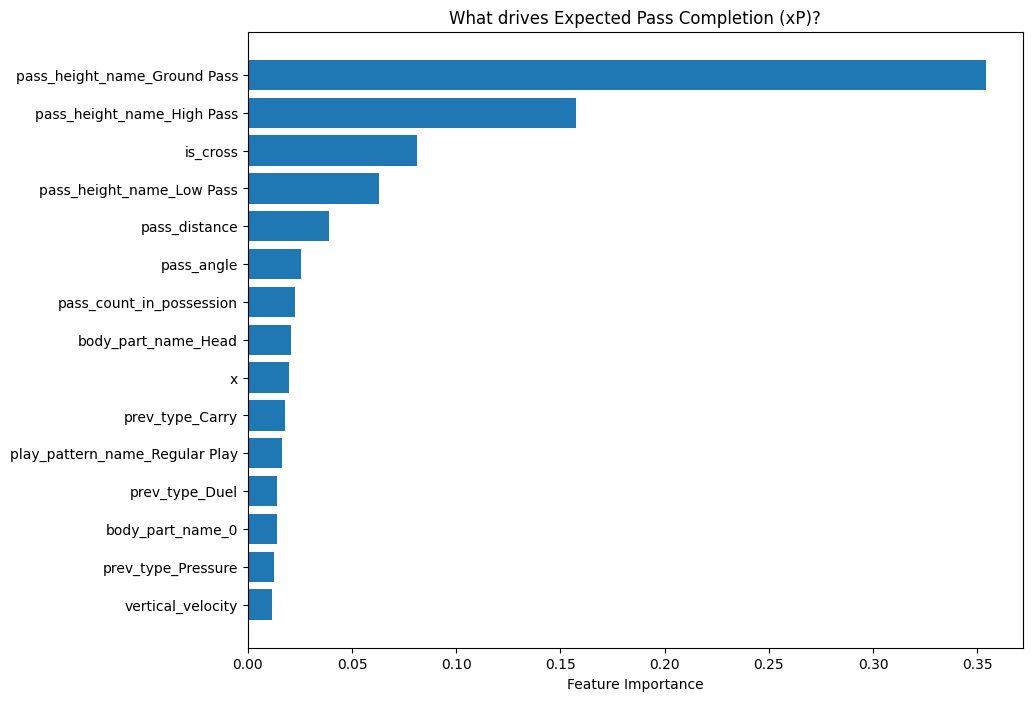

In [70]:
plt.figure(figsize=(10, 8))
# Get top 15 features
sorted_idx = model.feature_importances_.argsort()[-15:]
plt.barh(X_encoded.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("What drives Expected Pass Completion (xP)?")
plt.show()

In [71]:
X_full_encoded = pd.get_dummies(X, columns=[
    'body_part_name', 'play_pattern_name', 'pass_height_name', 'prev_type'
])
# Align columns (add missing columns with 0s if necessary)
X_full_encoded = X_full_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Save predictions to the main dataframe
df['xP'] = model.predict_proba(X_full_encoded)[:, 1]

print("\nSample xP Predictions:")
print(df[['player', 'pass_distance', 'pass_angle', 'success', 'xP']].head(10))


Sample xP Predictions:
                     player  pass_distance  pass_angle  success        xP
0         Antoine Griezmann      12.210242    2.692596        1  0.995236
1  Sergio Busquets i Burgos      15.471910   -1.720006        1  0.989329
2           Frenkie de Jong      24.489998    2.111216        1  0.992082
3     Gerard Piqué Bernabéu      20.763911   -1.730403        1  0.992909
4           Clément Lenglet      10.023971    0.499347        1  0.940093
5  Sergio Busquets i Burgos      23.129418    2.242836        1  0.987480
6     Gerard Piqué Bernabéu      24.148085   -1.851940        1  0.993673
7           Clément Lenglet      16.707483   -1.540865        1  0.974719
8          Jordi Alba Ramos      14.483784    1.240312        1  0.939879
9  Sergio Busquets i Burgos      33.092748    1.790121        1  0.988602


In [72]:
df

,Unnamed: 0,player,team_name,x,mirrored_y,pass_angle,pass_distance,body_part_name,is_cross,play_pattern_name,pass_height_name,pass_count_in_possession,prev_carry_distance,vertical_velocity,prev_action_is_teammate,prev_type,success,xP
0,0,Antoine Griezmann,Barcelona,61.0,0.1,2.692596,12.210242,Left Foot,0,From Kick Off,Ground Pass,0,0.000000,0.000000,0,Half Start,1,0.995236
1,1,Sergio Busquets i Burgos,Barcelona,49.4,4.9,-1.720006,15.471910,Right Foot,0,From Kick Off,Ground Pass,1,0.000000,0.000000,1,Ball Receipt*,1,0.989329
2,2,Frenkie de Jong,Barcelona,48.1,10.4,2.111216,24.489998,Right Foot,0,From Kick Off,Ground Pass,2,1.000000,-0.325000,1,Carry,1,0.992082
3,3,Gerard Piqué Bernabéu,Barcelona,44.3,10.2,-1.730403,20.763911,Right Foot,0,From Kick Off,Ground Pass,3,8.809086,-0.760000,1,Carry,1,0.992909
4,4,Clément Lenglet,Barcelona,49.0,11.3,0.499347,10.023971,Left Foot,0,From Kick Off,Ground Pass,4,8.062258,1.175000,1,Carry,1,0.940093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40332,40332,Marc Bartra Aregall,Real Betis,18.3,17.3,0.892134,15.929846,Right Foot,0,From Keeper,Ground Pass,2,3.006659,-1.533333,1,Carry,1,0.980993
40333,40333,Emerson Aparecido Leite de Souza Junior,Real Betis,28.3,29.7,0.431018,15.079125,Right Foot,0,From Keeper,Ground Pass,3,0.000000,5.000000,1,Carry,1,0.937140
40334,40334,Aitor Ruibal García,Real Betis,42.0,36.0,-0.241643,36.356292,Right Foot,0,From Keeper,Low Pass,4,0.000000,4.566667,1,Carry,0,0.448440
40335,40335,Rodrigo Sánchez Rodriguez,Real Betis,64.5,33.7,-0.592785,57.994569,Left Foot,0,From Free Kick,High Pass,0,0.000000,-0.220690,1,Foul Won,0,0.359431


In [73]:
df['PAx'] = df['success'] - df['xP']

In [74]:
df.head()

,Unnamed: 0,player,team_name,x,mirrored_y,pass_angle,pass_distance,body_part_name,is_cross,play_pattern_name,pass_height_name,pass_count_in_possession,prev_carry_distance,vertical_velocity,prev_action_is_teammate,prev_type,success,xP,PAx
0,0,Antoine Griezmann,Barcelona,61.0,0.1,2.692596,12.210242,Left Foot,0,From Kick Off,Ground Pass,0,0.000000,0.000,0,Half Start,1,0.995236,0.004764
1,1,Sergio Busquets i Burgos,Barcelona,49.4,4.9,-1.720006,15.471910,Right Foot,0,From Kick Off,Ground Pass,1,0.000000,0.000,1,Ball Receipt*,1,0.989329,0.010671
2,2,Frenkie de Jong,Barcelona,48.1,10.4,2.111216,24.489998,Right Foot,0,From Kick Off,Ground Pass,2,1.000000,-0.325,1,Carry,1,0.992082,0.007918
3,3,Gerard Piqué Bernabéu,Barcelona,44.3,10.2,-1.730403,20.763911,Right Foot,0,From Kick Off,Ground Pass,3,8.809086,-0.760,1,Carry,1,0.992909,0.007091
4,4,Clément Lenglet,Barcelona,49.0,11.3,0.499347,10.023971,Left Foot,0,From Kick Off,Ground Pass,4,8.062258,1.175,1,Carry,1,0.940093,0.059907


In [75]:
df = df.drop(columns=['Unnamed: 0'])

In [76]:
df.head()

,player,team_name,x,mirrored_y,pass_angle,pass_distance,body_part_name,is_cross,play_pattern_name,pass_height_name,pass_count_in_possession,prev_carry_distance,vertical_velocity,prev_action_is_teammate,prev_type,success,xP,PAx
0,Antoine Griezmann,Barcelona,61.0,0.1,2.692596,12.210242,Left Foot,0,From Kick Off,Ground Pass,0,0.000000,0.000,0,Half Start,1,0.995236,0.004764
1,Sergio Busquets i Burgos,Barcelona,49.4,4.9,-1.720006,15.471910,Right Foot,0,From Kick Off,Ground Pass,1,0.000000,0.000,1,Ball Receipt*,1,0.989329,0.010671
2,Frenkie de Jong,Barcelona,48.1,10.4,2.111216,24.489998,Right Foot,0,From Kick Off,Ground Pass,2,1.000000,-0.325,1,Carry,1,0.992082,0.007918
3,Gerard Piqué Bernabéu,Barcelona,44.3,10.2,-1.730403,20.763911,Right Foot,0,From Kick Off,Ground Pass,3,8.809086,-0.760,1,Carry,1,0.992909,0.007091
4,Clément Lenglet,Barcelona,49.0,11.3,0.499347,10.023971,Left Foot,0,From Kick Off,Ground Pass,4,8.062258,1.175,1,Carry,1,0.940093,0.059907


In [77]:
df.to_csv("xp_model.csv")